In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print("Boston housing dataset has {} data points with {} variables each.".format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each.


The target variable, ‘MEDV’, will be the variable we seek to predict. We will store it in prices.

In [3]:
# Minimum price of the data
minimum_price = np.amin(prices)

# Maximum price of the data
maximum_price = np.amax(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429477


## Inital Assumptions

- Houses with more rooms (higher ‘RM’ value) will worth more. Usually houses with more rooms are bigger and can fit more people, so it is reasonable that they cost more money. They are directly proportional variables.

- Neighborhoods with more lower class workers (higher ‘LSTAT’ value) will worth less. If the percentage of lower working class people is higher, it is likely that they have low purchasing power and therefore, they houses will cost less. They are inversely proportional variables.

- Neighborhoods with more students to teachers ratio (higher ‘PTRATIO’ value) will be worth less. If the percentage of students to teachers ratio people is higher, it is likely that in the neighborhood there are less schools, this could be because there is less tax income which could be because in that neighborhood people earn less money. If people earn less money it is likely that their houses are worth less. They are inversely proportional variables.

We’ll find out if these assumptions are correct.

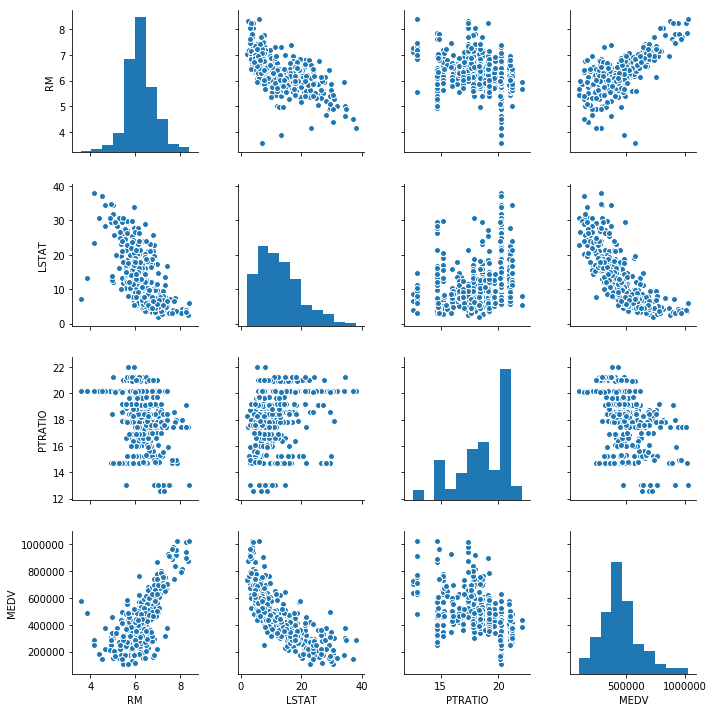

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Calculate and show pairplot
sns.pairplot(data, size=2.5)
plt.tight_layout()

Spot the linear relationship between ‘RM’ and House prices ‘MEDV’. In addition, we can infer from the histogram that the ‘MEDV’ variable seems to be normally distributed but contain several outliers.

Now, we'll create a correlation matrix to quantify and summarize the relationships btween the variables.

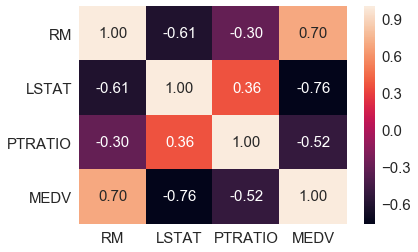

In [11]:
# Calculate and show correlation matrix
cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=data.columns,
                xticklabels=data.columns)

Notice the boxes with a high correlation with the target variable 'MEDV'.

# Developing the prediction model

We need to calculate the coefficient of determination, R², to quantify the model’s performance.

In [18]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculate and returns the performance score between true (y_true) 
    and predicted (y_predic) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score -- value should be between 0 and 1 to indicate a percentage
    return score

In [19]:
# Import 'tran_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testng subsets
X_train, X_test, y_train, y_test = train_test_split(features, prices, 
                                                    test_size=0.2, random_state = 42)

# Success 
print("Training and testing split was successful.")

Training and testing split was successful.


# Analyzing the model's performance

## 1. Learning curves

The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased.

Note that the shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R2, the coefficient of determination.

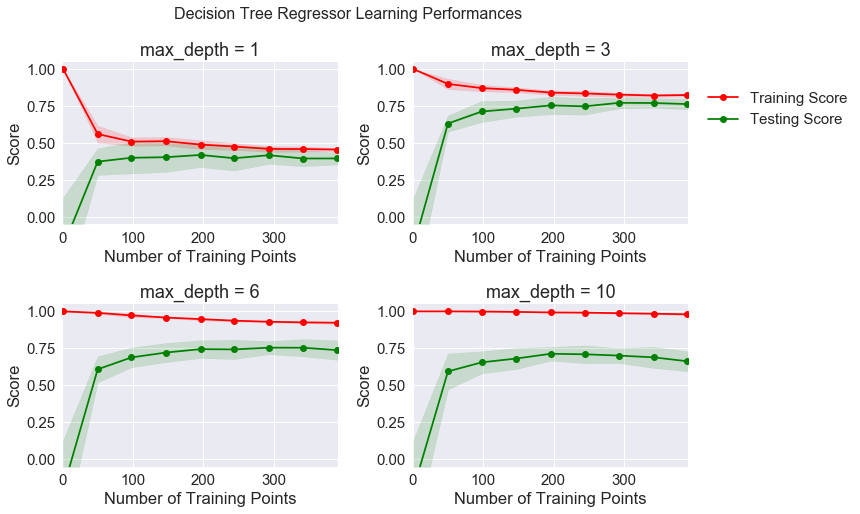

In [20]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(features, prices)

If we take a close look at the graph with the max depth of 3:
- As the number of training points increases, the training score decreases. In contrast, the test score increases.
- As both scores (training and testing) tend to converge, from the 300 points treshold, having more training points will not benefit the model.
- In general, with more columns for each observation, we’ll get more information and the model will be able to learn better from the dataset and therefore, make better predictions.

## 2. Complexity curves

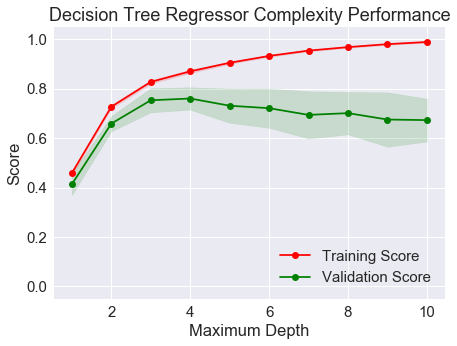

In [21]:
# Produce complexity curve for varying training set sizes and maximum depths
vs.ModelComplexity(X_train, y_train)

From the complexity curve, we can infer that the best maximum depth for the model is 4, as it is the one that yields the best validation score.

In addition, for more depth although the training score increases, validation score tends to decrease which is a sign of overfitting.

In [22]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [23]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


# Predicting Selling Prices

Imagine that we were a real estate agent in the Boston area looking to use this model to help price homes owned by our clients that they wish to sell. We have collected the following information from three of our clients:

Total # of rooms in home
Neighborhood poverty level (as %)
Student-teacher ratio of nearby schools

- What price would we recommend each client sell his/her home at?

- Do these prices seem reasonable given the values for the respective features?

In [24]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $403,025.00
Predicted selling price for Client 2's home: $237,478.72
Predicted selling price for Client 3's home: $931,636.36


# Conclusions

Our initial assumptions of the features are confirmed:

- ‘RM’, has a directy proportional relationship with the dependent variable ‘Prices’.
- In contrast, ‘LSTAT’ and ‘PTRATIO’ have a inversely proportional relationship with the dependent variable ‘PRICES’.

In [25]:
vs.PredictTrials(features, prices, fit_model, client_data)

Trial 1: $391,183.33
Trial 2: $419,700.00
Trial 3: $415,800.00
Trial 4: $420,622.22
Trial 5: $418,377.27
Trial 6: $411,931.58
Trial 7: $399,663.16
Trial 8: $407,232.00
Trial 9: $351,577.61
Trial 10: $413,700.00

Range in prices: $69,044.61


# Final Takeaways

Now, we use these results to discuss whether the constructed model should or should not be used in a real-world setting. Some questions that are worth to answer are:
- How relevant today is data that was collected from 1978? How important is inflation?

Data collected from 1978 is not of much value in today’s world. Society and economics have changed so much and inflation has made a great impact on the prices.
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?

The dataset considered is quite limited, there are a lot of features, like the size of the house in square feet, the presence of pool or not, and others, that are very relevant when considering a house price.
- Is the model robust enough to make consistent predictions?

Given the high variance on the prince range, we can assure that it is not a robust model and, therefore, not appropiate for making predictions.
- Would data collected in an urban city like Boston be applicable in a rural city?

Data collected from a big urban city like Boston would not be applicable in a rural city, as for equal value of feaures prices are much higher in the urban area.
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

In general it is not fair to estimate or predict the price of an indivual home based on the features of the entire neighborhood. In the same neighborhood there can be huge differences in prices.